# Imports

In [19]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense

import numpy as np
import matplotlib.pyplot as plt


# Load data

In [3]:
(train_ds, test_ds), ds_info = tfds.load("mnist", split =["train", "test"], as_supervised = True, with_info = True)

# Analyze Dataset

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\Test\\tensorflow_datasets\\mnist\\3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


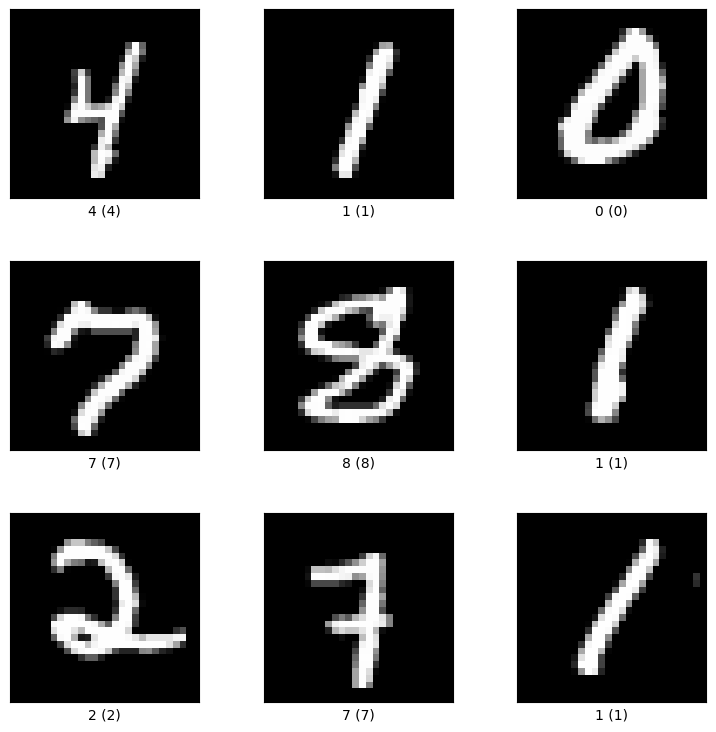

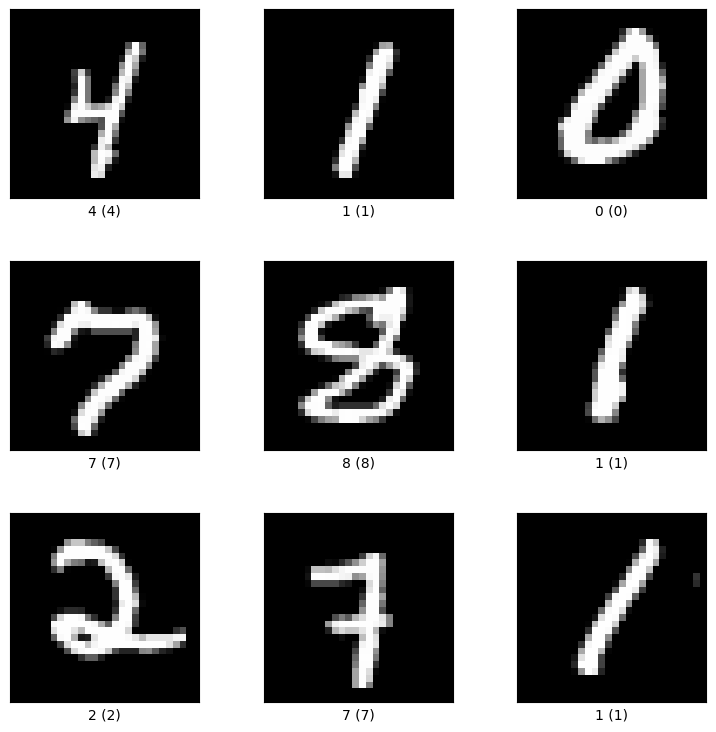

In [ ]:
tfds.show_examples(train_ds, ds_info)

### How many training/test images are there?
<br> *The training set contains 60000 examples, and the test set 10000 examples.* - http://yann.lecun.com/exdb/mnist/ 

### What’s the image shape?

In [ ]:
ds_info.features["image"].shape

(28, 28, 1)

### What range are pixel values in?

In [ ]:
ds_info.features["image"].tf_dtype

tf.uint8

Unsigned 8-bit (byte) integer: -> between **0** and **255**

# Prepare data

In [4]:
def preprocess_mnist_data(mnist_data):
    # cast image datatype from uint to float
    mnist_data = mnist_data.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten image to get a vector
    mnist_data = mnist_data.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # normalize the image to be between -1 and 1
    mnist_data = mnist_data.map(lambda img, target: ((img/128.)-1., target))

    # one-hot encode the target
    mnist_data = mnist_data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    #shuffle, batch, prefetch
    mnist_data = mnist_data.shuffle(1000)
    mnist_data = mnist_data.batch(32)
    mnist_data = mnist_data.prefetch(20)

    return mnist_data

In [5]:
train_dataset   = train_ds.apply(preprocess_mnist_data)
test_dataset    = test_ds.apply(preprocess_mnist_data)

# Create Model

In [6]:
class MnistModel(tf.keras.Model):
    
    def __init__(self):
        super(MnistModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256,    activation = tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256,    activation = tf.nn.relu)
        self.out    = tf.keras.layers.Dense(10,     activation = tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [7]:
model = MnistModel()

# Training

In [25]:
def train_model(epochs, model, train_ds, test_ds, loss_function, optimizer,\
                 train_losses, train_accuracies, test_losses, test_accuracies):
    
    for epoch in range(epochs):
        
        ### train model
        train_accuracy_aggregator   = []
        train_loss_aggregator       = []

        for inp, tar in train_ds:
            # train
            with tf.GradientTape() as tape:
                prediction  = model(inp)
                loss        = loss_function(tar, prediction)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # for log
            accuracy = np.argmax(tar, axis = 1) == np.argmax(prediction, axis=1)
            accuracy = np.mean(accuracy)
            
            train_loss_aggregator.append(loss.numpy())
            train_accuracy_aggregator.append(np.mean(accuracy))


        ### test model
        test_accuracy_aggregator    = []
        test_loss_aggregator        = []

        for inp, tar in test_ds:
            prediction  = model(inp)
            loss        = loss_function(tar, prediction)
            
            # for log
            accuracy = np.argmax(tar, axis = 1) == np.argmax(prediction, axis=1)
            accuracy = np.mean(accuracy)
            
            test_loss_aggregator.append(loss.numpy())
            test_accuracy_aggregator.append(np.mean(accuracy))

        # log
        train_losses.append     (tf.reduce_mean(train_loss_aggregator))
        train_accuracies.append (tf.reduce_mean(train_accuracy_aggregator))

        test_losses.append      (tf.reduce_mean(test_loss_aggregator))
        test_accuracies.append  (tf.reduce_mean(test_accuracy_aggregator))

    return train_losses, train_accuracies, test_losses, test_accuracies


In [15]:
# define hyperparameters
epochs          = 10
learning_rate   = 0.1
loss_function   = tf.keras.losses.CategoricalCrossentropy()
optimizer       = tf.keras.optimizers.SGD(learning_rate)

In [16]:
# define log lists
train_losses        = []
train_accuracies    = []
test_losses         = []
test_accuracies     = []

In [26]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model, train_dataset, test_dataset, loss_function, optimizer,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

In [20]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies):
    """ Visualizes accuracy and loss for training and test data using
    the mean of each epoch .
    Loss is displayed in a regular line , accuracy in a dotted
    line .
    Training data is displayed in blue , test data in red .
    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    test_losses : numpy . ndarray
    test losses
    test_accuracies : numpy . ndarray
    test accuracies
    """
    plt.figure ()
    line1, = plt.plot(train_losses, "b-" )
    line2, = plt.plot(test_losses, "r-" )
    line3, = plt.plot(train_accuracies, "b:" )
    line4, = plt.plot(test_accuracies, "r:" )
    plt.xlabel( "Training steps" )
    plt.ylabel( "Loss/Accuracy" )
    plt.legend(( line1 , line2 , line3 , line4 ), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

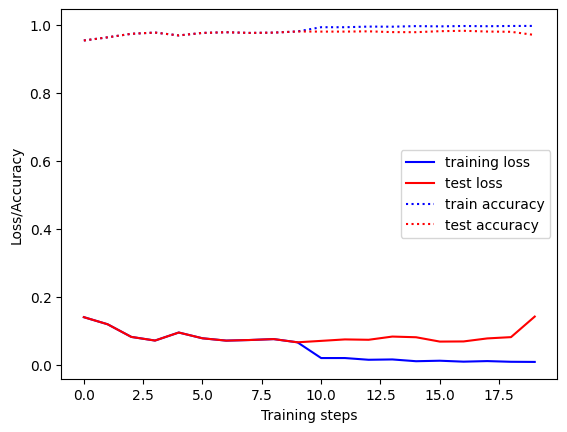

In [27]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

# hyperparameter tuning

In [32]:
class MnistModel_2(tf.keras.Model):
    
    def __init__(self):
        super(MnistModel_2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128,    activation = tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(128,    activation = tf.nn.relu)
        self.out    = tf.keras.layers.Dense(10,     activation = tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [35]:
model_less_nodes        = MnistModel_2()
optimizer_less_nodes    = tf.keras.optimizers.SGD(learning_rate)

In [36]:
# train
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_less_nodes, train_dataset, test_dataset, loss_function, optimizer_less_nodes,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

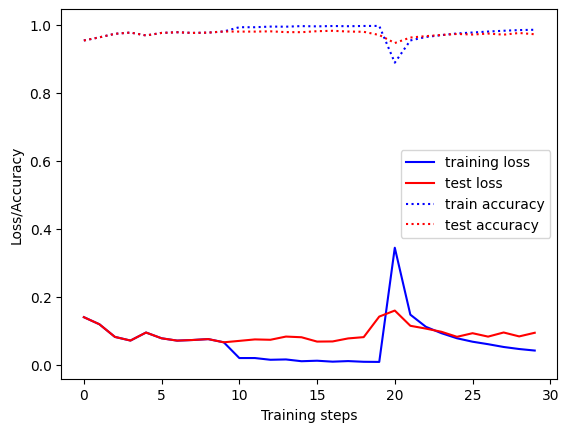

In [37]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

With less nodes we get a only small decrease in accuracy but a spike appears while training. Maybe tring to leave a local minimum

In [38]:
model_with_momentum         = MnistModel()
optimizer_SGD_with_momentum = tf.keras.optimizers.SGD(learning_rate, momentum = 0.1)

In [39]:
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_with_momentum, train_dataset, test_dataset, loss_function, optimizer_SGD_with_momentum,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

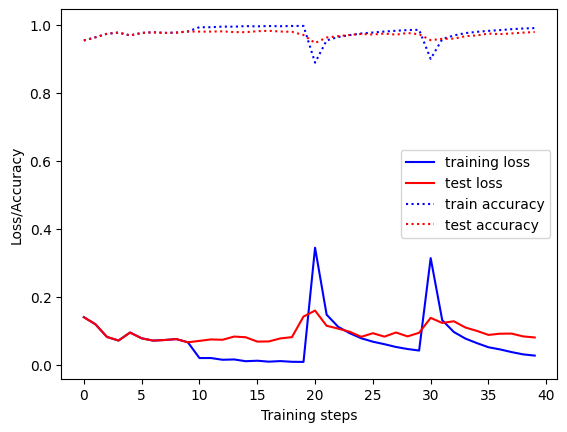

In [40]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

With momentum we get a really high accuracy and see that the momentum cause more spikes by leaving local minimums.

In [41]:
class MnistModel_mini(tf.keras.Model):
    
    def __init__(self):
        super(MnistModel_mini, self).__init__()
        self.dense1 = tf.keras.layers.Dense(2,    activation = tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(2,    activation = tf.nn.relu)
        self.out    = tf.keras.layers.Dense(10,     activation = tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [43]:
model_mini = MnistModel_mini()
optimizer_mini = tf.keras.optimizers.SGD(learning_rate)

In [44]:
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_mini, train_dataset, test_dataset, loss_function, optimizer_mini,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

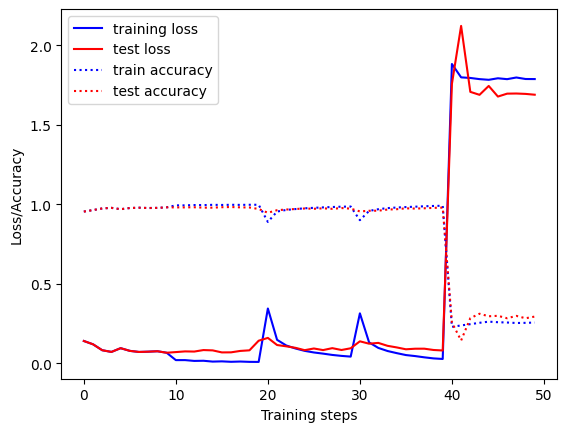

In [45]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

First we get a really good accuracy for the low numbers of nodes, but at the end the loss explodes. Maybe we should use for this less epochs. But it's faster

In [48]:
model_high_learning_rate        = MnistModel()
learning_rate_high              = learning_rate * 2
optimizer_high_learning_rate    = tf.keras.optimizers.SGD(learning_rate_high)

In [49]:
train_losses, train_accuracies, test_losses, test_accuracies = train_model(epochs, model_high_learning_rate, train_dataset, test_dataset, loss_function, optimizer_high_learning_rate,\
                                                                            train_losses, train_accuracies, test_losses, test_accuracies)

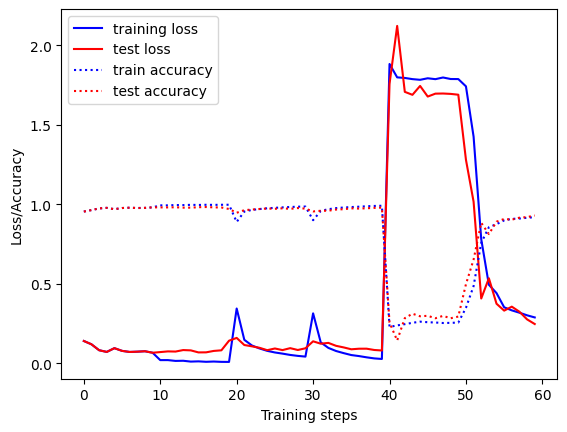

In [50]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

Maybe the training goes faster, but we have bigger spikes in loss at the end and so a drop in accuracy.